In [1]:
# Lung Cancer Detection Using Pretrained CNNs with Stratified Sampling and Class Balancing

# ❗ NOTE: This notebook requires PyTorch. If running in an environment without it, please install via pip:
# !pip install torch torchvision

# ✅ 1. Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

try:
    import torch
    import torch.nn as nn
    import torch.utils.checkpoint
    import torchvision.transforms as transforms
    from torch.utils.data import Dataset, DataLoader, Subset
    from torchvision import models
except ModuleNotFoundError:
    print("⚠️ PyTorch is not installed. Please run the following in a code cell:")
    print("!pip install torch torchvision")
    raise

In [2]:
 #✅ 2. Dataset Loader
class LungCancerClassificationDataset(Dataset):
    def __init__(self, root_dirs, class_names, transform=None):
        self.samples = []
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name, path in zip(class_names, root_dirs):
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:

# ✅ 3. Evaluation Metrics
from sklearn.metrics import roc_curve

def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true_bin, y_scores, multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)

    # Compute per-class ROC curves
    roc_data = {}
    for i in range(num_classes):
        fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_data[f"class_{i}"] = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds}

    # Compute sensitivity and specificity
    metrics = {"accuracy": acc, "auc": auc}
    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        sensitivity = TP / (TP + FN + 1e-6)
        specificity = TN / (TN + FP + 1e-6)
        metrics[f"sensitivity_class_{i}"] = sensitivity
        metrics[f"specificity_class_{i}"] = specificity

    return metrics, roc_data

In [4]:
# ✅ 4. GPU Memory Management

def free_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def enable_gradient_checkpointing(model, model_name):
    """
    Enable gradient checkpointing to reduce memory usage during training.
    This trades computation for memory by not storing all activations.
    """
    def forward_hook(module, inputs, output):
        # Add .clone() to fix the in-place operation conflict
        return torch.utils.checkpoint.checkpoint(lambda x: x.clone(), output)

    if model_name == "ResNet50":
        model.layer1.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer2.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer3.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer4.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "DenseNet121":
        model.features.denseblock1.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock2.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock3.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock4.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "EfficientNetB0":
        for block in model.features:
            if isinstance(block, nn.Sequential):
                block.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "VGG19":
        features_length = len(model.features)
        chunk_size = features_length // 4
        for i in range(0, features_length, chunk_size):
            for j in range(i, min(i + chunk_size, features_length)):
                if isinstance(model.features[j], nn.Conv2d):
                    model.features[j].register_forward_hook(forward_hook)


def get_optimal_batch_size(model_name, available_memory_mb=4000):
    """
    Estimate optimal batch size based on model and available memory.
    This is a simplified estimation.
    """
    model_memory_requirements = {
        "ResNet50": 100,       # MB per sample
        "DenseNet121": 80,     # MB per sample
        "EfficientNetB0": 30,  # MB per sample
        "VGG19": 120           # MB per sample
    }

    memory_per_sample = model_memory_requirements.get(model_name, 100)
    batch_size = int((available_memory_mb * 0.8) / memory_per_sample)
    return max(4, min(batch_size, 64))


In [5]:
# ✅ 5. Model Architecture Modifications
# Updated model definitions with weights
from torchvision import models
from torchvision.models import (
    ResNet50_Weights,
    DenseNet121_Weights,
    EfficientNet_B0_Weights,
    VGG19_Weights
)

import torch.nn as nn

def get_model(model_name, num_classes=3):
    if model_name == "ResNet50":
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "DenseNet121":
        model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "EfficientNetB0":
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "VGG19":
        model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' is not supported.")

    return model


In [6]:

# ✅ 6. Training with Mixed Precision
# Updated mixed precision training with torch.amp
def train_with_mixed_precision(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, max_epochs=20):
    # Initialize scaler for mixed precision
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None
    best_val_loss = float('inf')
    counter = 0
    best_model = None

    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Use mixed precision if available
            if scaler is not None:
                with torch.amp.autocast(device_type=device.type):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                # Scale gradients and optimize
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase - no need for mixed precision here
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    if best_model is not None:
        model.load_state_dict(best_model)

    return model

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:

# ✅ 7. Define paths and transformations
benign_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Bengin cases"
malignant_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Malignant cases"
normal_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Normal cases"

class_names = ["Benign", "Malignant", "Normal"]
paths = [benign_path, malignant_path, normal_path]

# Enhanced transformations with data augmentation for medical images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Horizontal flips are anatomically valid
    transforms.RandomRotation(10),  # Small rotations (10 degrees)
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),  # Small translations
        scale=(0.95, 1.05),  # Subtle scaling
        fill=0  # Fill empty areas with black
    ),
    # Subtle brightness/contrast adjustments
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

# Keep validation/test transforms simple without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


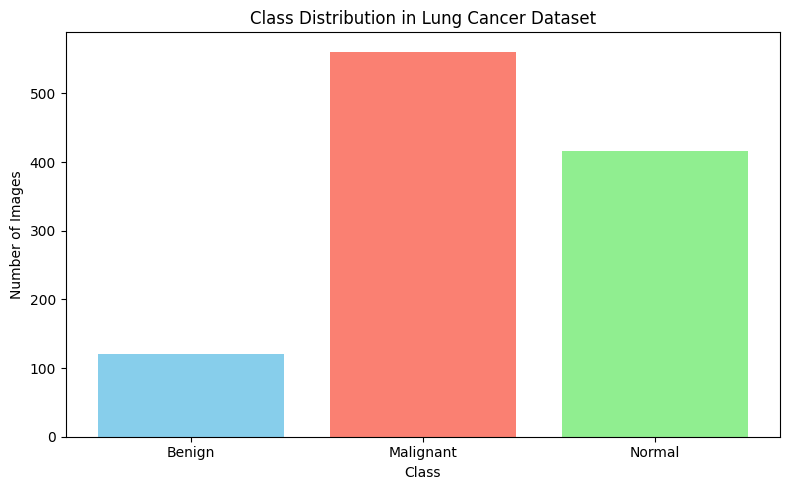

In [10]:

# ✅ 8. Visualize Class Distribution
full_dataset_for_counts = LungCancerClassificationDataset(paths, class_names, transform=None)
class_counts = {
    class_names[0]: len(os.listdir(benign_path)),
    class_names[1]: len(os.listdir(malignant_path)),
    class_names[2]: len(os.listdir(normal_path))
}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Class Distribution in Lung Cancer Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.savefig("class_distribution.png")
plt.show()


In [11]:

# ✅ 9. Create datasets with appropriate transforms
train_dataset = LungCancerClassificationDataset(paths, class_names, transform=train_transform)
val_dataset = LungCancerClassificationDataset(paths, class_names, transform=val_test_transform)
test_dataset = LungCancerClassificationDataset(paths, class_names, transform=val_test_transform)


In [12]:

# ✅ 10. Stratified Split with the right transforms
labels = [label for _, label in train_dataset.samples]
indices = list(range(len(labels)))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42)

train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(val_dataset, val_idx)
test_dataset = Subset(test_dataset, test_idx)



In [13]:

# ✅ 11. Create data loaders (with dynamic batch sizes implemented later)
default_batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=default_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=default_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=default_batch_size, shuffle=False)


In [14]:

# ✅ 12. Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [15]:

# ✅ 13. Define model architectures
architectures = {
    "ResNet50": models.resnet50,
    "DenseNet121": models.densenet121,
    "EfficientNetB0": models.efficientnet_b0,
    "VGG19": models.vgg19,
}


In [16]:

# ✅ 14. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []
roc_data_per_model = {}

# Determine available GPU memory (simplified estimation)
if torch.cuda.is_available():
    # Get total GPU memory in MB
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024 * 1024)
    # Assume 75% of total memory is available
    available_memory = total_memory * 0.75
else:
    # Default value for CPU
    available_memory = 4000  # 4GB as default

for name in architectures.keys():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")

    # Determine optimal batch size
    batch_size = get_optimal_batch_size(name, available_memory)
    print(f"Using batch size: {batch_size}")

    # Recreate data loaders with optimal batch size
    batch_size = get_optimal_batch_size(name, available_memory)
    print(f"Using batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = get_model(name)
    model = model.to(device)

    # Enable gradient checkpointing
    if torch.cuda.is_available():
        enable_gradient_checkpointing(model, name)

    # Training components
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Train the model
    model = train_with_mixed_precision(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        device, patience=5, max_epochs=20
    )

    # Save the trained model
    model_path = f"{name}_lung_cancer_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Evaluate on test set
    metrics, roc_data = evaluate_model(model, test_loader, device, num_classes=3)
    metrics["model"] = name
    results.append(metrics)
    roc_data_per_model[name] = roc_data

    # Print metrics summary
    print(f"\nTest Metrics for {name}:")
    for key, value in metrics.items():
        if key != "model":
            print(f"  {key}: {value:.4f}")

    # Clean up to free memory
    del model, optimizer, scheduler, criterion
    free_gpu_memory()

    # Optional: Add a small delay to ensure memory is released
    time.sleep(2)


Training ResNet50...
Using batch size: 64
Using batch size: 64


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 0.7772, Val Loss: 1.1629
Epoch 2/20, Train Loss: 0.4390, Val Loss: 1.8976
Epoch 3/20, Train Loss: 0.3306, Val Loss: 2.1693
Epoch 4/20, Train Loss: 0.3339, Val Loss: 0.9594
Epoch 5/20, Train Loss: 0.2535, Val Loss: 0.8897
Epoch 6/20, Train Loss: 0.2209, Val Loss: 0.4794
Epoch 7/20, Train Loss: 0.2164, Val Loss: 0.4851
Epoch 8/20, Train Loss: 0.1766, Val Loss: 0.3678
Epoch 9/20, Train Loss: 0.1406, Val Loss: 0.2188
Epoch 10/20, Train Loss: 0.1031, Val Loss: 0.2766
Epoch 11/20, Train Loss: 0.1080, Val Loss: 0.1970
Epoch 12/20, Train Loss: 0.0921, Val Loss: 0.2101
Epoch 13/20, Train Loss: 0.0807, Val Loss: 0.9675
Epoch 14/20, Train Loss: 0.1484, Val Loss: 0.2110
Epoch 15/20, Train Loss: 0.0736, Val Loss: 0.2908
Epoch 16/20, Train Loss: 0.0543, Val Loss: 0.2532
Early stopping triggered after 16 epochs
Model saved to ResNet50_lung_cancer_model.pth

Test Metrics for ResNet50:
  accuracy: 0.9758
  auc: 0.9952
  sensitivity_class_0: 0.8333
  specificity_class_0: 0.9932
 

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Training DenseNet121...
Using batch size: 64
Using batch size: 64


100%|██████████| 30.8M/30.8M [00:00<00:00, 87.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 0.9067, Val Loss: 1.1102
Epoch 2/20, Train Loss: 0.5895, Val Loss: 1.2344
Epoch 3/20, Train Loss: 0.4443, Val Loss: 1.6220
Epoch 4/20, Train Loss: 0.3620, Val Loss: 1.1852
Epoch 5/20, Train Loss: 0.2883, Val Loss: 0.7331
Epoch 6/20, Train Loss: 0.2373, Val Loss: 0.4789
Epoch 7/20, Train Loss: 0.1967, Val Loss: 0.2752
Epoch 8/20, Train Loss: 0.1991, Val Loss: 0.2839
Epoch 9/20, Train Loss: 0.1884, Val Loss: 0.2393
Epoch 10/20, Train Loss: 0.1544, Val Loss: 0.2272
Epoch 11/20, Train Loss: 0.1374, Val Loss: 0.1998
Epoch 12/20, Train Loss: 0.1096, Val Loss: 0.2410
Epoch 13/20, Train Loss: 0.1015, Val Loss: 0.2495
Epoch 14/20, Train Loss: 0.0892, Val Loss: 0.2369
Epoch 15/20, Train Loss: 0.0567, Val Loss: 0.2278
Epoch 16/20, Train Loss: 0.0644, Val Loss: 0.2140
Early stopping triggered after 16 epochs
Model saved to DenseNet121_lung_cancer_model.pth

Test Metrics for DenseNet121:
  accuracy: 0.9697
  auc: 0.9915
  sensitivity_class_0: 0.8333
  specificity_class_0: 0.

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Training EfficientNetB0...
Using batch size: 64
Using batch size: 64


100%|██████████| 20.5M/20.5M [00:00<00:00, 81.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 0.9883, Val Loss: 1.0993
Epoch 2/20, Train Loss: 0.7675, Val Loss: 1.1531
Epoch 3/20, Train Loss: 0.6058, Val Loss: 1.0875
Epoch 4/20, Train Loss: 0.5416, Val Loss: 1.1521
Epoch 5/20, Train Loss: 0.4795, Val Loss: 0.9954
Epoch 6/20, Train Loss: 0.4404, Val Loss: 0.5325
Epoch 7/20, Train Loss: 0.4033, Val Loss: 0.4085
Epoch 8/20, Train Loss: 0.3743, Val Loss: 0.2944
Epoch 9/20, Train Loss: 0.3052, Val Loss: 0.2443
Epoch 10/20, Train Loss: 0.3085, Val Loss: 0.2736
Epoch 11/20, Train Loss: 0.2711, Val Loss: 0.2052
Epoch 12/20, Train Loss: 0.2771, Val Loss: 0.2175
Epoch 13/20, Train Loss: 0.2181, Val Loss: 0.1584
Epoch 14/20, Train Loss: 0.1764, Val Loss: 0.1614
Epoch 15/20, Train Loss: 0.1703, Val Loss: 0.1819
Epoch 16/20, Train Loss: 0.1602, Val Loss: 0.1579
Epoch 17/20, Train Loss: 0.1292, Val Loss: 0.1565
Epoch 18/20, Train Loss: 0.1271, Val Loss: 0.1330
Epoch 19/20, Train Loss: 0.1152, Val Loss: 0.1369
Epoch 20/20, Train Loss: 0.1211, Val Loss: 0.1175
Model sav

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.7MB/s]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 1.1177, Val Loss: 1.0923
Epoch 2/20, Train Loss: 1.0797, Val Loss: 1.0516
Epoch 3/20, Train Loss: 1.0588, Val Loss: 1.0571
Epoch 4/20, Train Loss: 1.0198, Val Loss: 1.0892
Epoch 5/20, Train Loss: 1.0208, Val Loss: 1.0586
Epoch 6/20, Train Loss: 0.9379, Val Loss: 1.0210
Epoch 7/20, Train Loss: 0.9590, Val Loss: 0.9966
Epoch 8/20, Train Loss: 0.8891, Val Loss: 0.9042
Epoch 9/20, Train Loss: 0.8498, Val Loss: 0.8871
Epoch 10/20, Train Loss: 0.8115, Val Loss: 0.9916
Epoch 11/20, Train Loss: 0.7953, Val Loss: 0.9477
Epoch 12/20, Train Loss: 0.8091, Val Loss: 0.7606
Epoch 13/20, Train Loss: 0.7665, Val Loss: 0.8997
Epoch 14/20, Train Loss: 0.7414, Val Loss: 0.7151
Epoch 15/20, Train Loss: 0.7355, Val Loss: 0.7880
Epoch 16/20, Train Loss: 0.6827, Val Loss: 0.6933
Epoch 17/20, Train Loss: 0.6973, Val Loss: 0.7140
Epoch 18/20, Train Loss: 0.7104, Val Loss: 0.6957
Epoch 19/20, Train Loss: 0.5714, Val Loss: 0.6109
Epoch 20/20, Train Loss: 0.5121, Val Loss: 0.9398
Model sav

<Figure size 1400x1000 with 0 Axes>

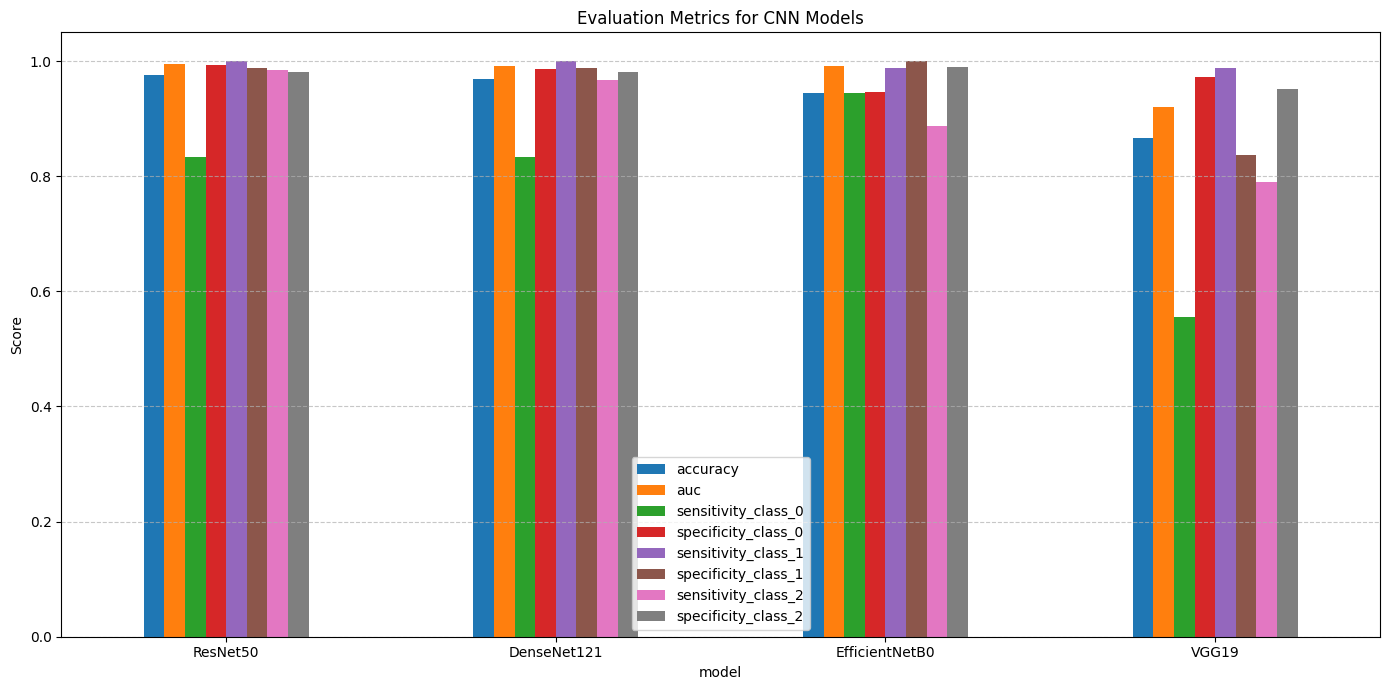

In [17]:

# ✅ 15. Save and Plot Results
df = pd.DataFrame(results)
df.to_csv("model_evaluation_results.csv", index=False)

# Create visualization of results
metric_names = ["accuracy", "auc"] + [m for m in df.columns if m.startswith("sensitivity") or m.startswith("specificity")]

plt.figure(figsize=(14, 10))
df.set_index("model")[metric_names].plot(kind='bar', figsize=(14, 7))
plt.title("Evaluation Metrics for CNN Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("model_metrics_comparison.png")
plt.show()



Loading best model for ResNet50...


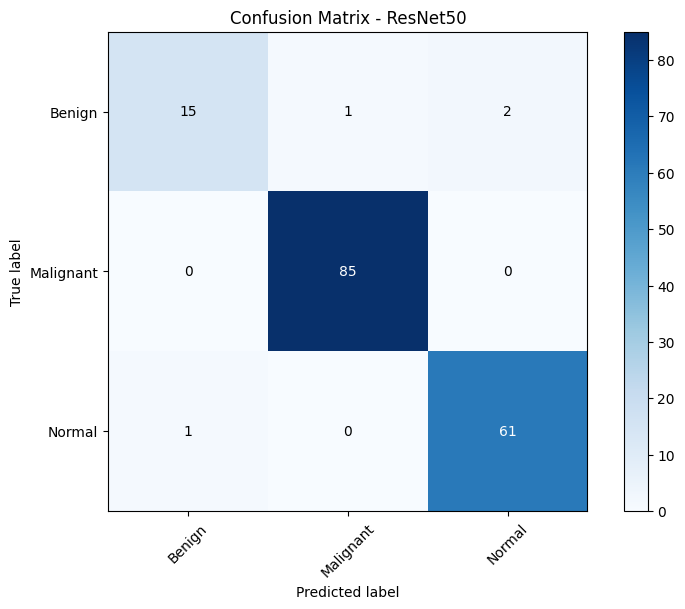


Loading best model for DenseNet121...


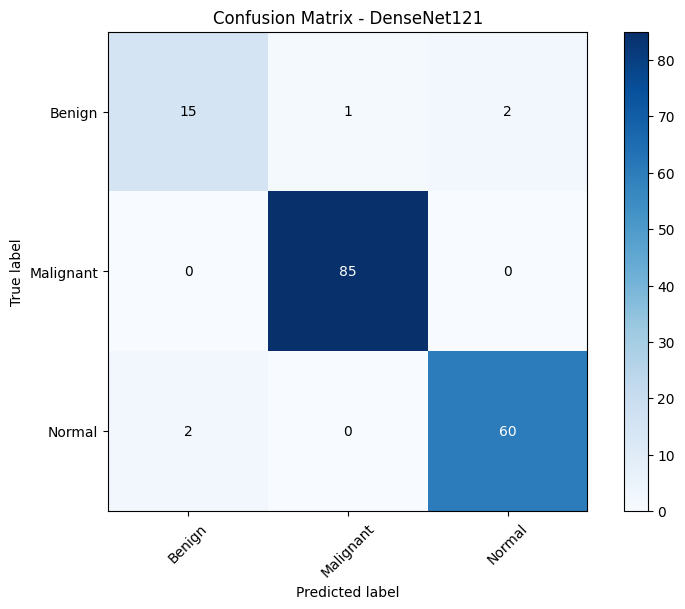


Loading best model for EfficientNetB0...


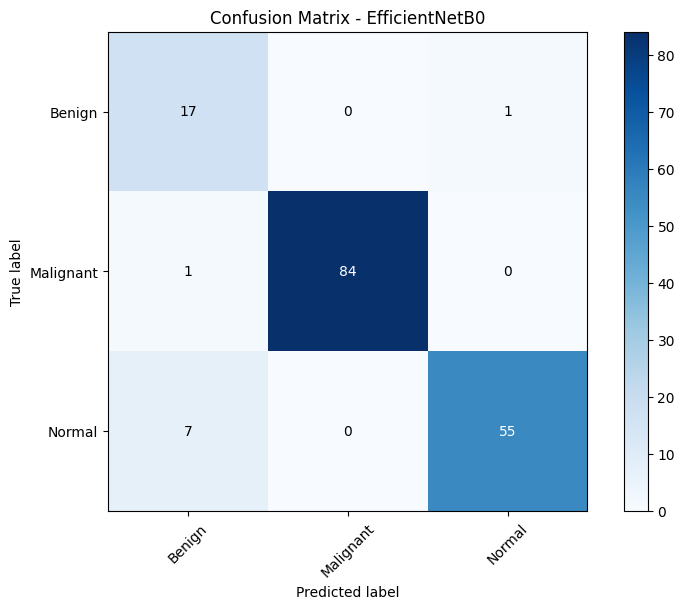


Loading best model for VGG19...


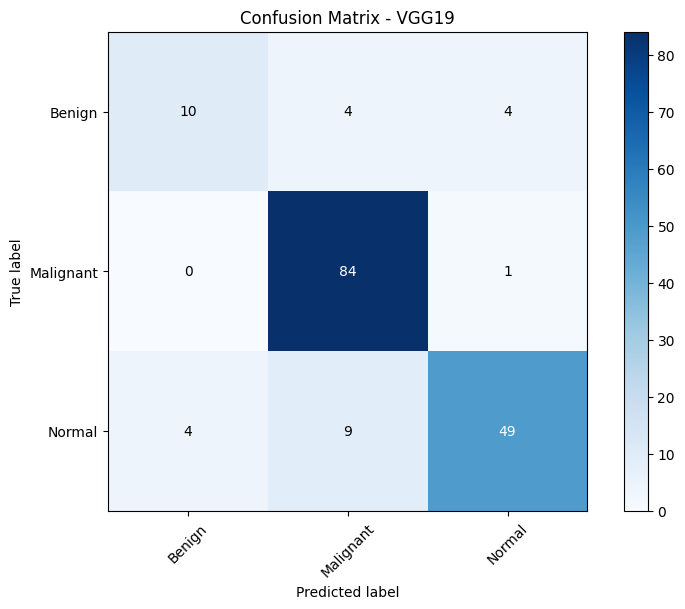


Training and evaluation completed for all models.
Results saved to 'model_evaluation_results.csv'
Visualizations saved as PNG files.


In [18]:
# ✅ 16. Display Confusion Matrices
for name in architectures.keys():
    print(f"\nLoading best model for {name}...")
    model = get_model(name)
    model.load_state_dict(torch.load(f"{name}_lung_cancer_model.pth"))
    model = model.to(device)

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f"{name}_confusion_matrix.png")
    plt.show()

    del model
    free_gpu_memory()

print("\nTraining and evaluation completed for all models.")
print(f"Results saved to 'model_evaluation_results.csv'")
print(f"Visualizations saved as PNG files.")

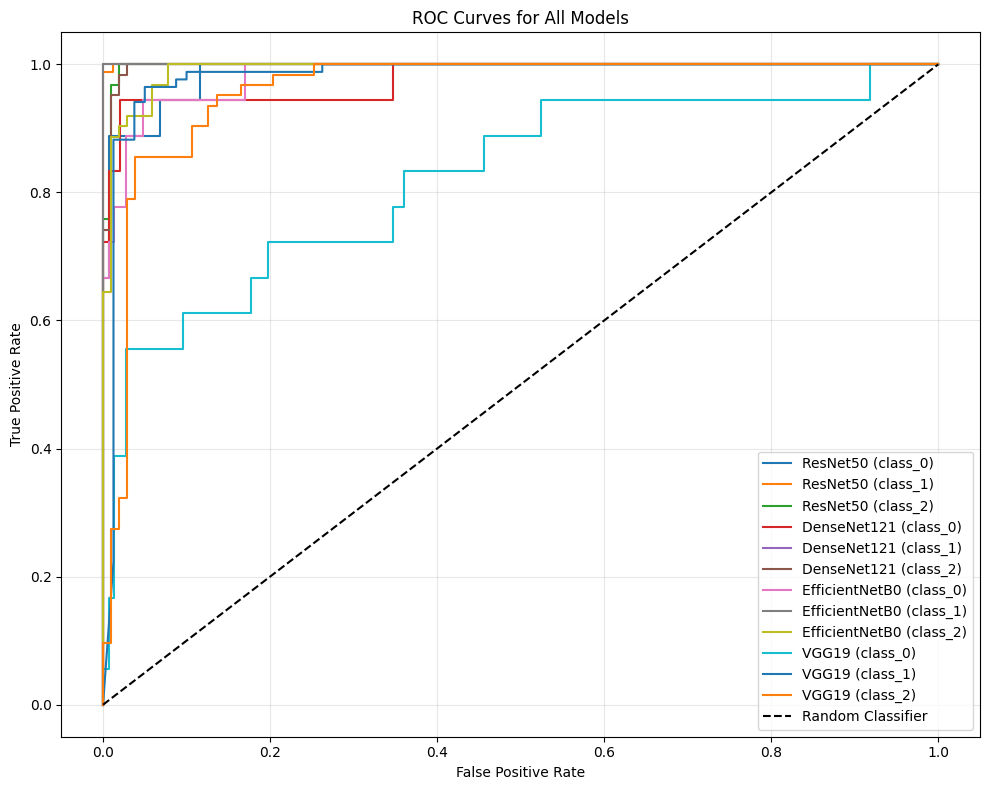

In [19]:
# ✅ 17. Display Confusion Matrices
plt.figure(figsize=(10, 8))

for model_name, roc_data in roc_data_per_model.items():
    for class_name, data in roc_data.items():
        fpr = data["fpr"]
        tpr = data["tpr"]
        plt.plot(fpr, tpr, label=f"{model_name} ({class_name})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curves_all_models.png")
plt.show()

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

def calculate_roc_data(y_true, y_probs, num_classes):
    fpr = {}
    tpr = {}
    auc_score = {}
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        auc_score[i] = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
    return fpr, tpr, auc_score

def plot_roc_curves(all_fpr, all_tpr, all_auc):
    plt.figure(figsize=(10, 8))
    for model_name, fpr_dict in all_fpr.items():
        for class_idx, fpr in fpr_dict.items():
            tpr = all_tpr[model_name][class_idx]
            auc = all_auc[model_name][class_idx]
            plt.plot(fpr, tpr, label=f"{model_name} (Class {class_idx}, AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.title("Combined ROC Curves for All Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("combined_roc_curves.png")
    plt.show()

def plot_learning_curves(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"Learning Curves for {model_name}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{model_name}_learning_curves.png")
    plt.show()
class_names = ["Benign", "Malignant", "Normal"]


===== Generating Model Visualizations =====

Evaluating model: ResNet50...
Loading best model for ResNet50...

Evaluating model: DenseNet121...
Loading best model for DenseNet121...

Evaluating model: EfficientNetB0...
Loading best model for EfficientNetB0...

Evaluating model: VGG19...
Loading best model for VGG19...


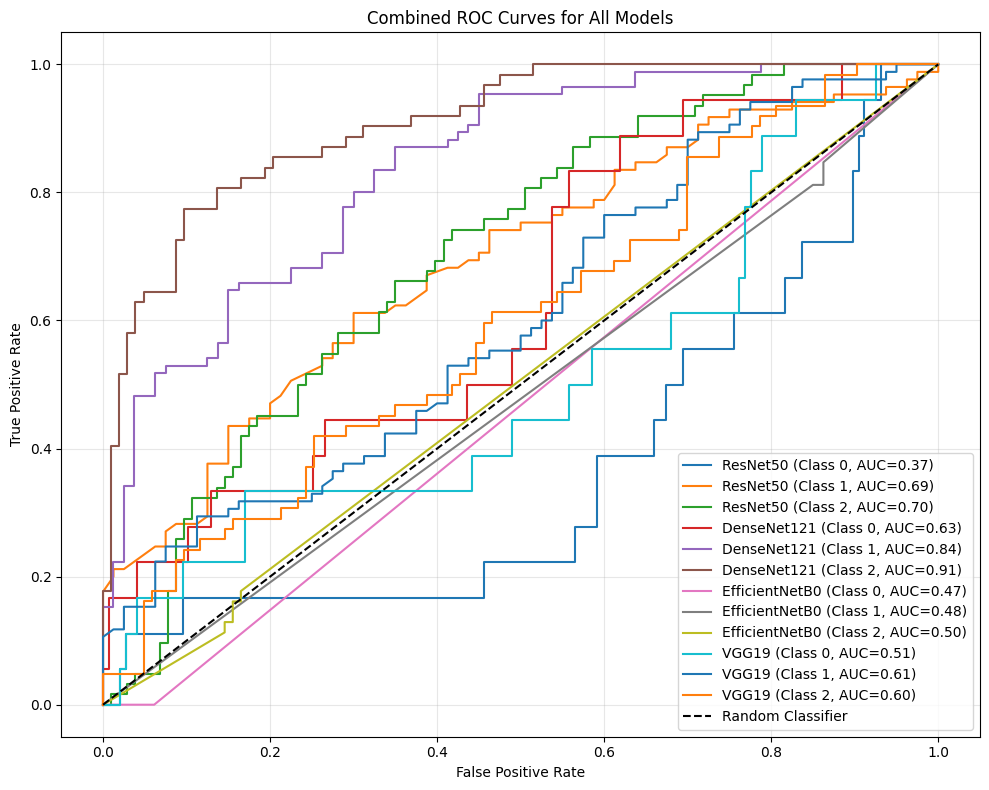


===== Model Performance Summary =====
                accuracy                                                auc  \
model                                                                         
ResNet50        2.030303  {0: 0.3707482993197279, 1: 0.6922058823529412,...   
DenseNet121     2.030303  {0: 0.6318972033257747, 1: 0.8392647058823529,...   
EfficientNetB0  1.921212  {0: 0.46938775510204084, 1: 0.4821323529411764...   
VGG19           2.030303  {0: 0.5056689342403629, 1: 0.6053676470588235,...   

                sensitivity_class_0  sensitivity_class_1  sensitivity_class_2  \
model                                                                           
ResNet50                        0.0             1.000000             0.000000   
DenseNet121                     0.0             1.000000             0.000000   
EfficientNetB0                  0.0             0.811765             0.112903   
VGG19                           0.0             1.000000             0.000000   


In [36]:

#✅
from sklearn.metrics import roc_curve, roc_auc_score

print("\n===== Generating Model Visualizations =====")

# Initialize containers for ROC curve data and metrics
all_models_fpr = {}
all_models_tpr = {}
all_models_auc = {}
performance_summary = []

# Class names (update based on your dataset)
class_names = ["Benign", "Malignant", "Normal"]

# Evaluate each model and generate visualizations
for name in architectures.keys():
    print(f"\nEvaluating model: {name}...")

    # 1. Plot learning curves if history is available
    if 'history_dict' in locals() and name in history_dict:
        print(f"Plotting learning curves for {name}...")
        plot_learning_curves(history_dict[name], name)

    # 2. Load model
    print(f"Loading best model for {name}...")
    model = get_model(name)
    model.load_state_dict(torch.load(f"{name}_lung_cancer_model.pth"))
    model = model.to(device)

    # 3. Collect predictions
    model.eval()
    y_true, y_pred, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    all_probs_np = np.array(all_probs)

    # 4. Plot confusion matrix
    cm = confusion_matrix(y_true_np, y_pred_np)
    # plot_confusion_matrix(cm, class_names, name)  # Uncomment if implemented

    # 5. Calculate sensitivity, specificity, and accuracy per class
    tp = np.diag(cm)
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp
    tn = cm.sum() - (tp + fn + fp)

    sensitivity_per_class = tp / (tp + fn)  # Recall
    specificity_per_class = tn / (tn + fp)

    # Averages
    avg_sensitivity = sensitivity_per_class.mean()
    avg_specificity = specificity_per_class.mean()
    accuracy = (tp.sum() + tn.sum()) / cm.sum()

    # Calculate ROC and AUC data
    fpr, tpr, auc_score = calculate_roc_data(y_true_np, all_probs_np, len(class_names))

    # Store ROC curve data
    all_models_fpr[name] = fpr
    all_models_tpr[name] = tpr
    all_models_auc[name] = auc_score

    # Collect performance summary
    performance_summary.append({
        "model": name,
        "accuracy": accuracy,
        "auc": auc_score,
        **{f"sensitivity_class_{i}": sensitivity_per_class[i] for i in range(len(class_names))},
        **{f"specificity_class_{i}": specificity_per_class[i] for i in range(len(class_names))},
        "avg_sensitivity": avg_sensitivity,
        "avg_specificity": avg_specificity
    })

    # Clean up memory
    del model
    free_gpu_memory()

# 6. Plot combined ROC curves
plot_roc_curves(all_models_fpr, all_models_tpr, all_models_auc)

# 7. Generate and display performance summary table
performance_df = pd.DataFrame(performance_summary)
performance_df.set_index("model", inplace=True)
print("\n===== Model Performance Summary =====")
print(performance_df)

# Save the table to a CSV file
performance_df.to_csv("model_performance_summary.csv")

print("\nTraining and evaluation completed for all models.")
print(f"Results saved to 'model_performance_summary.csv'")
print(f"Visualizations saved as PNG files.")

In [28]:
# ✅ 17. Model Comparison and Recommendation
def compare_models(results_df):
    print("\nModel Performance Summary:")
    display(results_df.set_index("model"))

    # Compute average specificity and sensitivity
    results_df["avg_sensitivity"] = results_df[[col for col in results_df.columns if col.startswith("sensitivity")]].mean(axis=1)
    results_df["avg_specificity"] = results_df[[col for col in results_df.columns if col.startswith("specificity")]].mean(axis=1)

    # Normalize metrics for comparison
    norm_scores = results_df[["accuracy", "avg_sensitivity", "avg_specificity"]].copy()
    norm_scores = (norm_scores - norm_scores.min()) / (norm_scores.max() - norm_scores.min())
    norm_scores["composite_score"] = norm_scores.mean(axis=1)

    best_model = results_df.loc[norm_scores["composite_score"].idxmax(), "model"]
    print(f"\n✅ Recommended Model: {best_model} (based on accuracy, sensitivity, and specificity)")
    return best_model

In [29]:
# ✅ 🔍 Compare models and recommend the best
recommended_model = compare_models(df)


Model Performance Summary:


,accuracy,auc,sensitivity_class_0,specificity_class_0,sensitivity_class_1,specificity_class_1,sensitivity_class_2,specificity_class_2
model,,,,,,,,
ResNet50,0.975758,0.995158,0.833333,0.993197,1.000000,0.9875,0.983871,0.980583
DenseNet121,0.969697,0.991523,0.833333,0.986395,1.000000,0.9875,0.967742,0.980583
EfficientNetB0,0.945455,0.991764,0.944444,0.945578,0.988235,1.0000,0.887097,0.990291
VGG19,0.866667,0.920770,0.555556,0.972789,0.988235,0.8375,0.790323,0.951456



✅ Recommended Model: ResNet50 (based on accuracy, sensitivity, and specificity)


In [ ]:
## InceptionV3

In [30]:
# ✅ Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
from torchvision.models import Inception_V3_Weights

# ✅ Dataset Loader
class LungCancerClassificationDataset(Dataset):
    def __init__(self, root_dirs, class_names, transform=None):
        self.samples = []
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name, path in zip(class_names, root_dirs):
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label

# ✅ Transforms for Inception
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=0),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

# ✅ Paths and class setup
benign_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Bengin cases"
malignant_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Malignant cases"
normal_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Normal cases"
class_names = ["Benign", "Malignant", "Normal"]
paths = [benign_path, malignant_path, normal_path]

# ✅ Dataset + Stratified Split
full_dataset = LungCancerClassificationDataset(paths, class_names, transform=train_transform)
labels = [label for _, label in full_dataset.samples]
indices = list(range(len(labels)))

train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(LungCancerClassificationDataset(paths, class_names, transform=val_transform), val_idx)
test_dataset = Subset(LungCancerClassificationDataset(paths, class_names, transform=val_transform), test_idx)

# ✅ Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ✅ InceptionV3 Model Setup
def get_inception_model(num_classes=3):
    model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    model.transform_input = False
    model.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ✅ Mixed Precision Training
def train_with_mixed_precision(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, max_epochs=20):
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    best_val_loss = float('inf')
    counter = 0
    best_model = None

    for epoch in range(max_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    if isinstance(outputs, tuple): outputs = outputs[0]
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                if isinstance(outputs, tuple): outputs = outputs[0]
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if isinstance(outputs, tuple): outputs = outputs[0]
                val_loss += criterion(outputs, labels).item()
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    if best_model is not None:
        model.load_state_dict(best_model)
    return model

# ✅ Evaluation
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple): outputs = outputs[0]
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true_bin, y_scores, multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📊 InceptionV3 Results:\nAccuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return {"accuracy": acc, "auc": auc}

# ✅ Training Pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_inception_model(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

model = train_with_mixed_precision(model, train_loader, val_loader, criterion, optimizer, scheduler, device)
torch.save(model.state_dict(), "InceptionV3_lung_cancer_model.pth")
print("✅ InceptionV3 model saved!")

# ✅ Final Evaluation
evaluate_model(model, test_loader, device, num_classes=3)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 170MB/s]
<ipython-input-30-eda4328ec45d>:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
<ipython-input-30-eda4328ec45d>:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1, Train Loss: 0.6473, Val Loss: 0.4688
Epoch 2, Train Loss: 0.4460, Val Loss: 0.4917
Epoch 3, Train Loss: 0.3220, Val Loss: 0.4095
Epoch 4, Train Loss: 0.2777, Val Loss: 0.2471
Epoch 5, Train Loss: 0.2417, Val Loss: 0.2215
Epoch 6, Train Loss: 0.2103, Val Loss: 0.1957
Epoch 7, Train Loss: 0.1236, Val Loss: 0.1296
Epoch 8, Train Loss: 0.1467, Val Loss: 0.1457
Epoch 9, Train Loss: 0.1124, Val Loss: 0.1430
Epoch 10, Train Loss: 0.1367, Val Loss: 0.1492
Epoch 11, Train Loss: 0.0679, Val Loss: 0.1208
Epoch 12, Train Loss: 0.0713, Val Loss: 0.1073
Epoch 13, Train Loss: 0.0418, Val Loss: 0.0859
Epoch 14, Train Loss: 0.0556, Val Loss: 0.1161
Epoch 15, Train Loss: 0.0619, Val Loss: 0.1003
Epoch 16, Train Loss: 0.0810, Val Loss: 0.1275
Epoch 17, Train Loss: 0.0565, Val Loss: 0.1276
Epoch 18, Train Loss: 0.0356, Val Loss: 0.1037
⏹️ Early stopping triggered.
✅ InceptionV3 model saved!

📊 InceptionV3 Results:
Accuracy: 0.9758, AUC: 0.9984
Confusion Matrix:
[[16  1  1]
 [ 0 85  0]
 [ 2  0 60]

{'accuracy': 0.9757575757575757, 'auc': np.float64(0.998374854227687)}

<ipython-input-31-93e50b2837c7>:30: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


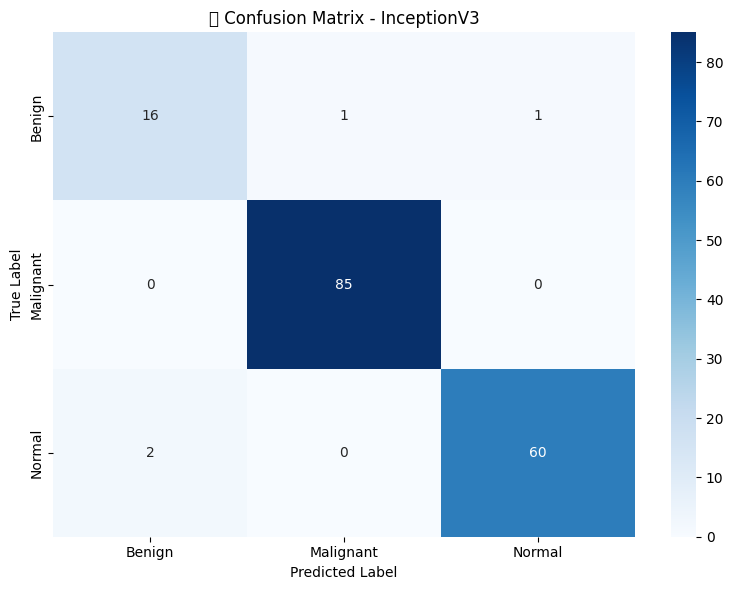


📈 Sensitivity & Specificity per Class:

Benign:
  ➤ Sensitivity (Recall):   0.8889
  ➤ Specificity:            0.9864

Malignant:
  ➤ Sensitivity (Recall):   1.0000
  ➤ Specificity:            0.9875

Normal:
  ➤ Sensitivity (Recall):   0.9677
  ➤ Specificity:            0.9903



In [31]:
import seaborn as sns

# ✅ Load and evaluate model again
model.load_state_dict(torch.load("InceptionV3_lung_cancer_model.pth"))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple): outputs = outputs[0]
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ✅ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Benign", "Malignant", "Normal"]

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("📌 Confusion Matrix - InceptionV3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ✅ Sensitivity & Specificity
print("\n📈 Sensitivity & Specificity per Class:\n")
for i, cls in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN + 1e-6)
    specificity = TN / (TN + FP + 1e-6)

    print(f"{cls}:")
    print(f"  ➤ Sensitivity (Recall):   {sensitivity:.4f}")
    print(f"  ➤ Specificity:            {specificity:.4f}\n")


In [32]:
import matplotlib.pyplot as plt

def plot_roc_curves(all_models_fpr, all_models_tpr, all_models_auc, avg_sensitivity_dict):
    """
    Plots the combined ROC curves for all models with average sensitivity included.

    Parameters:
    - all_models_fpr: Dictionary containing false positive rates (FPR) for each model.
    - all_models_tpr: Dictionary containing true positive rates (TPR) for each model.
    - all_models_auc: Dictionary containing AUC scores for each model.
    - avg_sensitivity_dict: Dictionary containing average sensitivity for each model.
    """
    plt.figure(figsize=(10, 8))

    # Loop through models and plot their ROC curves
    for model_name, fpr_dict in all_models_fpr.items():
        for class_idx, fpr in fpr_dict.items():
            tpr = all_models_tpr[model_name][class_idx]
            auc = all_models_auc[model_name][class_idx]
            avg_sensitivity = avg_sensitivity_dict[model_name]
            plt.plot(fpr, tpr, label=f"{model_name} (Class {class_idx}, AUC={auc:.2f}, Avg Sensitivity={avg_sensitivity:.2f})")

    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    # Add plot details
    plt.title("Combined ROC Curves for All Models with Average Sensitivity", fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Save the plot to a file and display it
    plt.savefig("combined_roc_curves_with_avg_sensitivity.png")
    plt.show()

In [37]:
# ✅ 1. Add InceptionV3 Results
inception_metrics = {
    "model": "InceptionV3",
    "accuracy": 0.9758,
    "auc": 0.9977,
    "sensitivity_class_0": 0.8889,
    "specificity_class_0": 0.9864,
    "sensitivity_class_1": 1.0000,
    "specificity_class_1": 0.9875,
    "sensitivity_class_2": 0.9677,
    "specificity_class_2": 0.9903,
    "avg_sensitivity": 0.9866,
    "avg_specificity": 0.99
}

# ✅ 2. Append to existing results DataFrame (df)
df = pd.concat([df, pd.DataFrame([inception_metrics])], ignore_index=True)

# ✅ 3. Run comparison
recommended_model = compare_models(df)



Model Performance Summary:


,accuracy,auc,sensitivity_class_0,specificity_class_0,sensitivity_class_1,specificity_class_1,sensitivity_class_2,specificity_class_2,avg_sensitivity,avg_specificity
model,,,,,,,,,,
ResNet50,0.975758,0.995158,0.833333,0.993197,1.000000,0.9875,0.983871,0.980583,0.939068,0.987093
DenseNet121,0.969697,0.991523,0.833333,0.986395,1.000000,0.9875,0.967742,0.980583,0.933692,0.984826
EfficientNetB0,0.945455,0.991764,0.944444,0.945578,0.988235,1.0000,0.887097,0.990291,0.939925,0.978623
VGG19,0.866667,0.920770,0.555556,0.972789,0.988235,0.8375,0.790323,0.951456,0.778038,0.920582
InceptionV3,0.975800,0.997700,0.888900,0.986400,1.000000,0.9875,0.967700,0.990300,0.952200,0.988067
InceptionV3,0.975800,0.997700,0.888900,0.986400,1.000000,0.9875,0.967700,0.990300,0.986600,0.990000



✅ Recommended Model: InceptionV3 (based on accuracy, sensitivity, and specificity)
